### Step 4

L'objectif ici est de développer un modèle de préférence additive pour aider à choisir une solution parmi les solutions non dominées obtenues dans les étapes précédentes.
La méthode UTA permet de construire un modèle de préférence additive en utilisant des fonctions d'utilité linéaires par morceaux pour chaque critère.

L'idée est de simuler les préférences du décideur en utilisant des poids pour chaque critère

On utilise dans un premier temps les données fournies dans le fichier Preferences.xlsx. Ensuite, on utilisera les solutions non dominées obtenues dans Step 3 comme entrée pour la méthode UTA.

Pour chaque critère, il construit une fonction d'utilité en :

divisant l'intervalle des valeurs en 4 points
déterminant la valeur d'utilité optimale à chaque point
permettant une interpolation linéaire entre ces points

Le modèle cherche à respecter deux principes :

Plus la valeur d'un critère est élevée, plus l'utilité (insatisfaction) augmente
Une solution mieux classée doit avoir une utilité globale plus faible que celle qui la suit

Set parameter LogToConsole to value 0
Erreur d'ajustement: 0.2439562975176628


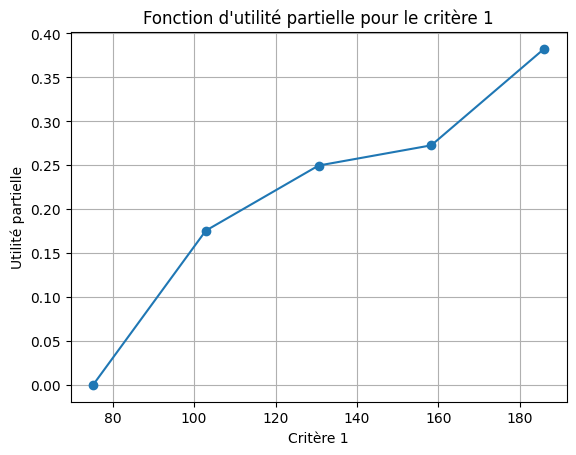

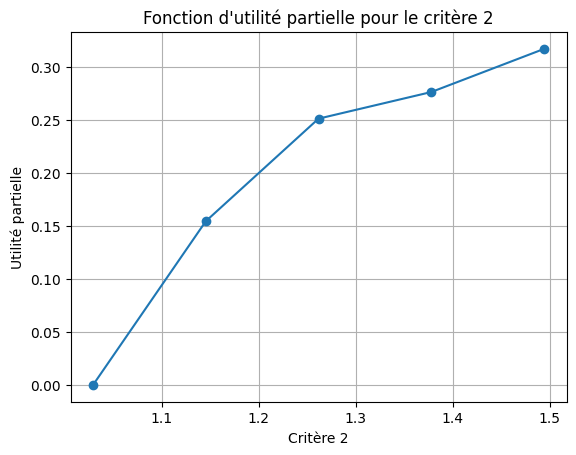

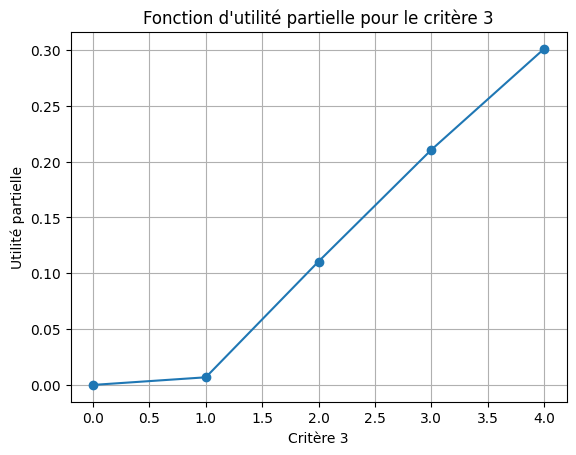

        distance  max_workload  #changed offices  utilite_globale
rank                                                             
1      83.722254      1.066358                 1         0.032654
2      86.064870      1.123243                 0         0.048427
3      89.663945      1.114196                 1         0.057960
4      80.186376      1.226844                 1         0.185964
5      79.227614      1.180500                 2         0.278463
6      75.214893      1.404830                 0         0.278473
7      83.308010      1.471083                 0         0.297105
8      82.397314      1.409648                 1         0.297115
9      81.466460      1.029212                 4         0.310724
10     91.784421      1.087131                 3         0.255943
11    103.318696      1.223812                 0         0.346500
12     94.123879      1.306550                 0         0.283436
13    117.857928      1.032420                 2         0.297165
14     88.

In [16]:
import gurobipy as gp
import pandas as pd
from gurobipy import GRB
import matplotlib.pyplot as plt

def plot_utility_functions(fonctions_utilite, points, valeurs_min, valeurs_max):
    for critere in range(1, 4):
        x_values = [valeurs_min[critere] + (valeurs_max[critere] - valeurs_min[critere]) * i / points[critere] for i in range(points[critere] + 1)]
        y_values = [fonctions_utilite[critere][i].X for i in range(points[critere] + 1)]
        
        plt.figure()
        plt.plot(x_values, y_values, marker='o')
        plt.xlabel(f'Critère {critere}')
        plt.ylabel('Utilité partielle')
        plt.title(f'Fonction d\'utilité partielle pour le critère {critere}')
        plt.grid(True)
        plt.show()

def optimize_preferences(data_path, epsilon=0.00001):
    #Charger et trier les prefs
    df_preferences = pd.read_excel(data_path, index_col=0)
    df_preferences = df_preferences.sort_index() 
    preferences_id = df_preferences.index.to_list()

    #Nombre de points de discrétisation pour chaque critère
    points = {1: 4, 
              2: 4, 
              3: 4}

    valeurs_min = {
        1: df_preferences["distance"].min(),
        2: df_preferences["max_workload"].min(),
        3: df_preferences["#changed offices"].min(),
    }

    valeurs_max = {
        1: df_preferences["distance"].max(),
        2: df_preferences["max_workload"].max(),
        3: df_preferences["#changed offices"].max(),
    }

    #Initialisation du modèle d'optimisation
    modele = gp.Model("Optimisation_Preferences")

    #Variables de décision
    fonctions_utilite = {
        critere: modele.addVars(points[critere] + 1, name=f"u_{critere}")
        for critere in range(1,4)
    }
    
    ecart_positif = modele.addVars(preferences_id, name="ecart_positif")
    ecart_negatif = modele.addVars(preferences_id, name="ecart_negatif")

    #Fonction d'utilité partielle pour un critère donné
    def utilite_partielle(critere, valeur_x):
        if valeur_x <= valeurs_min[critere]:
            return fonctions_utilite[critere][0]
        if valeur_x >= valeurs_max[critere]:
            return fonctions_utilite[critere][points[critere]]

        #Trouver l'intervalle correspondant
        index_k = int(points[critere] * (valeur_x - valeurs_min[critere]) /
                      (valeurs_max[critere] - valeurs_min[critere]))
        valeur_k = valeurs_min[critere] + (valeurs_max[critere] - valeurs_min[critere]) * index_k / points[critere]

        #Interpolation linéaire
        return fonctions_utilite[critere][index_k] + \
               (valeur_x - valeur_k) / (valeurs_max[critere] - valeurs_min[critere]) * (
                   fonctions_utilite[critere][index_k + 1] - fonctions_utilite[critere][index_k]
               )

    #Fonction d'utilité globale
    def utilite_globale(alternative):
        return sum(utilite_partielle(critere, alternative[critere]) for critere in range(1,4))

    #Fonction objectif : minimisation de l'erreur d'ajustement
    somme_ecarts = gp.quicksum(ecart_positif[a] + ecart_negatif[a] for a in preferences_id)
    modele.setObjective(somme_ecarts, GRB.MINIMIZE)

    #Contraintes sur les fonctions d'utilité partielle (croissantes)
    for critere in range(1,4):
        for index in range(points[critere]):
            modele.addConstr(fonctions_utilite[critere][index] + epsilon <= fonctions_utilite[critere][index + 1])

    #Normalisation : l'utilité minimale est 0 et la somme des max vaut 1
    for critere in range(1,4):
        modele.addConstr(fonctions_utilite[critere][0] == 0)
    modele.addConstr(gp.quicksum(fonctions_utilite[critere][points[critere]] for critere in range(1,4)) == 1)

    #Contraintes de respect des préférences
    for index in range(len(preferences_id) - 1):
        alt_actuelle = {
            1: df_preferences.loc[preferences_id[index], "distance"],
            2: df_preferences.loc[preferences_id[index], "max_workload"],
            3: df_preferences.loc[preferences_id[index], "#changed offices"],
        }
        alt_suivante = {
            1: df_preferences.loc[preferences_id[index + 1], "distance"],
            2: df_preferences.loc[preferences_id[index + 1], "max_workload"],
            3: df_preferences.loc[preferences_id[index + 1], "#changed offices"],
        }

        modele.addConstr(
            utilite_globale(alt_actuelle) - ecart_positif[preferences_id[index]] + ecart_negatif[preferences_id[index]] + epsilon
            <= utilite_globale(alt_suivante) - ecart_positif[preferences_id[index + 1]] + ecart_negatif[preferences_id[index + 1]]
        )

    #Résolution du modèle
    modele.params.LogToConsole = 0
    modele.optimize()

    print("Erreur d'ajustement:", modele.objVal)

    #Calcul et ajout de l'utilité globale aux alternatives
    df_preferences["utilite_globale"] = [
        utilite_globale({1: x[0], 2: x[1], 3: x[2]}).getValue() for x in df_preferences.values
    ]

    plot_utility_functions(fonctions_utilite, points, valeurs_min, valeurs_max)

    return df_preferences

#1ère Utilisation avec fichier preferences.xlsx:
resultats = optimize_preferences("./data/Preferences.xlsx")
print(resultats)

Set parameter LogToConsole to value 0


Erreur d'ajustement: 0.0


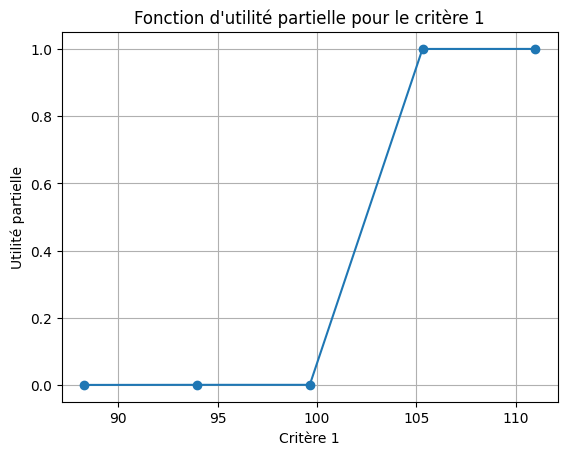

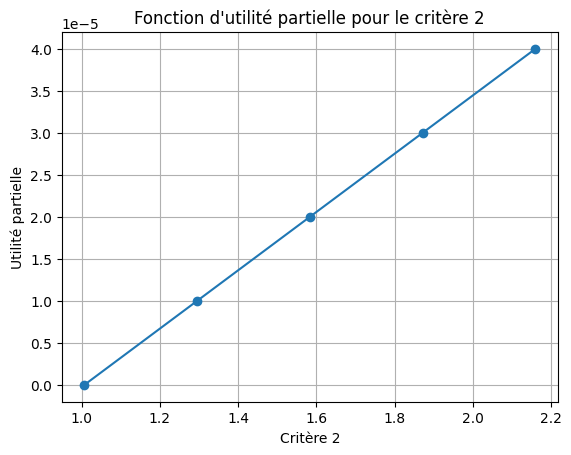

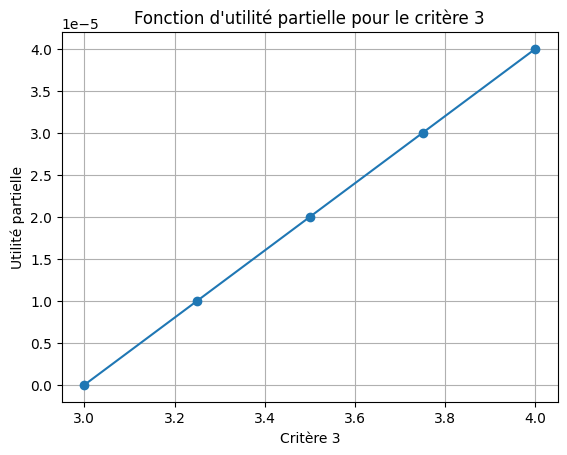

        distance  max_workload  #changed offices  utilite_globale
rank                                                             
1      88.301703      2.159600                 4         0.000080
2      90.939189      2.062099                 4         0.000102
3      93.497241      1.568500                 4         0.000112
4      97.206467      1.475500                 3         0.000272
5     102.168011      1.408400                 4         0.111947
6     102.785223      1.244400                 4         0.139154
7     103.416800      1.201700                 3         0.166962
8     103.563960      1.130700                 4         0.173490
9     106.597855      1.086600                 3         0.999863
10    109.332540      1.043900                 4         0.999910
11    110.971200      1.006800                 3         0.999920


In [15]:
resultats = optimize_preferences("./data/results.xlsx")
print(resultats)

Les solutions sont classées de la meilleure à la moins bonne en fonction de leur utilité globale.

La solution avec l'utilité la plus faible est considérée comme la meilleure selon les préférences du décideur.

La fonction est croissante, ce qui signifie que plus la distance est grande, plus l'utilité (donc l'insatisfaction) augmente

La solution #1 est effectivement la meilleure car elle minimise l'insatisfaction globale avec :
(Pour le cas des préferences des décideurs)
Une distance modérée (83.72)
Une charge de travail proche de 1 (1.066)
Un seul changement de bureau

Le modèle UTA a bien capturé les préférences où :

On évite les grandes distances
On préfère des charges de travail équilibrées (proches de 1)
On minimise les perturbations (changements de bureaux)